In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
import time
from datetime import datetime

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import multiprocessing

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    
    return tf.argmax(tf.cast(one_hot, tf.int32))

def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_TL(file_path):
    label = get_label(file_path)
    print(label)
    img = tf.io.read_file(file_path)

    img = decode_img(img)
    #img = tf.keras.applications.vgg16.preprocess_input(img)
    return img, label

Num GPUs Available:  1


In [2]:
img_height = 224
img_width = 224

base_dir = r'C:\Users\Szymon\intel_image'
train_dir = base_dir + '\\train'
val_dir = base_dir + '\\val'

train_files = tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=False)
val_files = tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False)

train_num_files=len([file for file in glob(str(train_dir + '\\*\\*'))])
val_num_files=len([file for file in glob(str(val_dir + '\\*\\*'))])
print(train_num_files)
print(val_num_files)

class_names = np.array(sorted([dir1 for dir1 in os.listdir(train_dir)]))
num_classes = len(class_names)

train_dataset = train_files.interleave(lambda x: tf.data.Dataset.list_files(str(train_dir + '\\*\\*'), shuffle=True), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_files.interleave(lambda x: tf.data.Dataset.list_files(str(val_dir + '\\*\\*'), shuffle=False), cycle_length=4).map(process_TL, num_parallel_calls=tf.data.experimental.AUTOTUNE)

14034
3000
Tensor("ArgMax:0", shape=(), dtype=int64)
Tensor("ArgMax:0", shape=(), dtype=int64)


In [3]:
data_augmentation = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomFlip('horizontal'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1)
    ])

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    data_augmentation,
    
    layers.Conv2D(filters=48,kernel_size=(3,3),padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.1),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.2),
    
    layers.Conv2D(filters=96, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.3),
    
    layers.Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.4),
    
    layers.Conv2D(filters=192, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.Dropout(0.5),
    
    layers.Flatten(),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 48)      1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 48)      192       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 48)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      27712     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)     

In [4]:
epoch = 50
batch_size = 32

train_dataset = train_dataset.repeat().shuffle(buffer_size=32).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)
train_dataset =train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset =val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

start_time= time.perf_counter()
model_train = model.fit(
    train_dataset,
    steps_per_epoch = int((train_num_files)/batch_size),
    validation_data = val_dataset,
    validation_steps = int(val_num_files/batch_size),
    epochs=epoch)

print(time.perf_counter()-start_time)

Epoch 1/50
438/438 [==============================] - 135s 284ms/step - loss: 1.5506 - accuracy: 0.4999 - val_loss: 0.7587 - val_accuracy: 0.7325
Epoch 2/50
438/438 [==============================] - 126s 288ms/step - loss: 1.0939 - accuracy: 0.6019 - val_loss: 1.0180 - val_accuracy: 0.6062
Epoch 3/50
438/438 [==============================] - 125s 286ms/step - loss: 0.9872 - accuracy: 0.6398 - val_loss: 0.9060 - val_accuracy: 0.6344
Epoch 4/50
438/438 [==============================] - 125s 285ms/step - loss: 0.9166 - accuracy: 0.6644 - val_loss: 0.8389 - val_accuracy: 0.6626
Epoch 5/50
438/438 [==============================] - 129s 293ms/step - loss: 0.8713 - accuracy: 0.6796 - val_loss: 0.9341 - val_accuracy: 0.6452
Epoch 6/50
438/438 [==============================] - 127s 290ms/step - loss: 0.8042 - accuracy: 0.7026 - val_loss: 1.3294 - val_accuracy: 0.4906
Epoch 7/50
438/438 [==============================] - 129s 295ms/step - loss: 0.7810 - accuracy: 0.7200 - val_loss: 0.5384 -

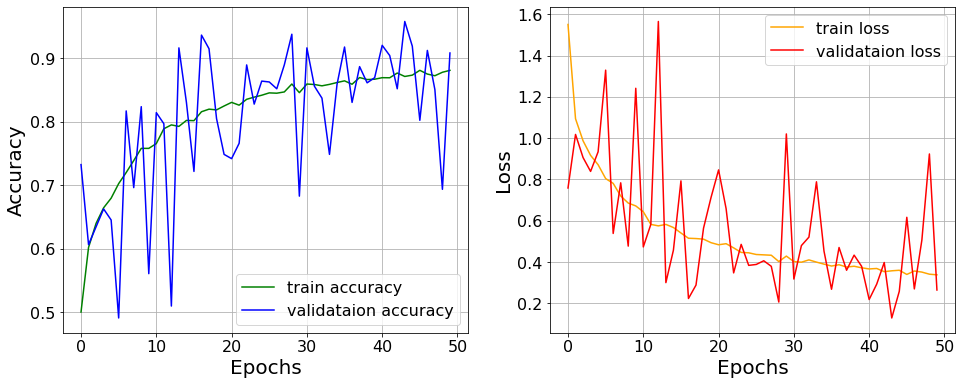

In [5]:
train_loss = model_train.history['loss']
train_acc = model_train.history['accuracy']
valid_loss = model_train.history['val_loss']
valid_acc = model_train.history['val_accuracy']

plt.figure(figsize=(16, 6))

plt.subplot(1,2,1)
plt.plot(train_acc, color='green', linestyle='-', label='train accuracy')
plt.plot(valid_acc, color='blue', linestyle='-', label='validataion accuracy')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()


plt.subplot(1,2,2)
plt.plot(train_loss, color='orange', linestyle='-', label='train loss')
plt.plot(valid_loss, color='red', linestyle='-', label='validataion loss')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.grid()

plt.savefig('results.png')

In [6]:
model.save('own_intel.h5')